# Introduction

In [1]:
# Import libraries and check the versions
import pandas as pd
import sys
import numpy as np
import sklearn
import matplotlib as mpl
import seaborn as sns
import missingno as msno
import xgboost as xgb


print('Python version: {}'.format(sys.version))
print('Numpy version {}'.format(np.__version__))
print('Pandas version {}'.format(pd.__version__))
print('Matplotlib version {}'.format(mpl.__version__))
print('Seaborn version {}'.format(sns.__version__))
print('Sklearn version: {}'.format(sklearn.__version__))
print('Missingno version: {}'.format(msno.__version__))
print("Xgboost version: {}".format(xgb.__version__))

# Pretty display for notebooks
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# for more clear plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

Python version: 3.6.5 |Anaconda custom (64-bit)| (default, Apr 26 2018, 08:42:37) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Numpy version 1.13.3
Pandas version 0.23.0
Matplotlib version 2.2.2
Seaborn version 0.8.1
Sklearn version: 0.19.1
Missingno version: 0.3.5
Xgboost version: 0.7


### 1. Data Collection

This dataset can be found at kaggle's website. First column of the dataset is the index column and we specify that with index_col = 0. Let's see the first five records of the dataset.

In [2]:
# retrieve the data
df = pd.read_csv('h1b_kaggle.csv', index_col=[0])
df.head()

/anaconda/lib/python3.6/site-packages/numpy/lib/arraysetops.py:463: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158
4,CERTIFIED-WITHDRAWN,"GATES CORPORATION, A WHOLLY-OWNED SUBSIDIARY O...",CHIEF EXECUTIVES,"REGIONAL PRESIDEN, AMERICAS",Y,220314.0,2016.0,"DENVER, COLORADO",-104.990251,39.739236
5,WITHDRAWN,PEABODY INVESTMENTS CORP.,CHIEF EXECUTIVES,PRESIDENT MONGOLIA AND INDIA,Y,157518.4,2016.0,"ST. LOUIS, MISSOURI",-90.199404,38.627003


### 2. Data Wrangling

Before we do explonatary data analysis, we need to select necessary features and clean the data. 

In [3]:
# select the features that will be used creating the model
data = df[['CASE_STATUS', 'SOC_NAME',
       'FULL_TIME_POSITION', 'PREVAILING_WAGE', 'WORKSITE']]

Missigno is a library that allows us to visualize missing data in the dataset.

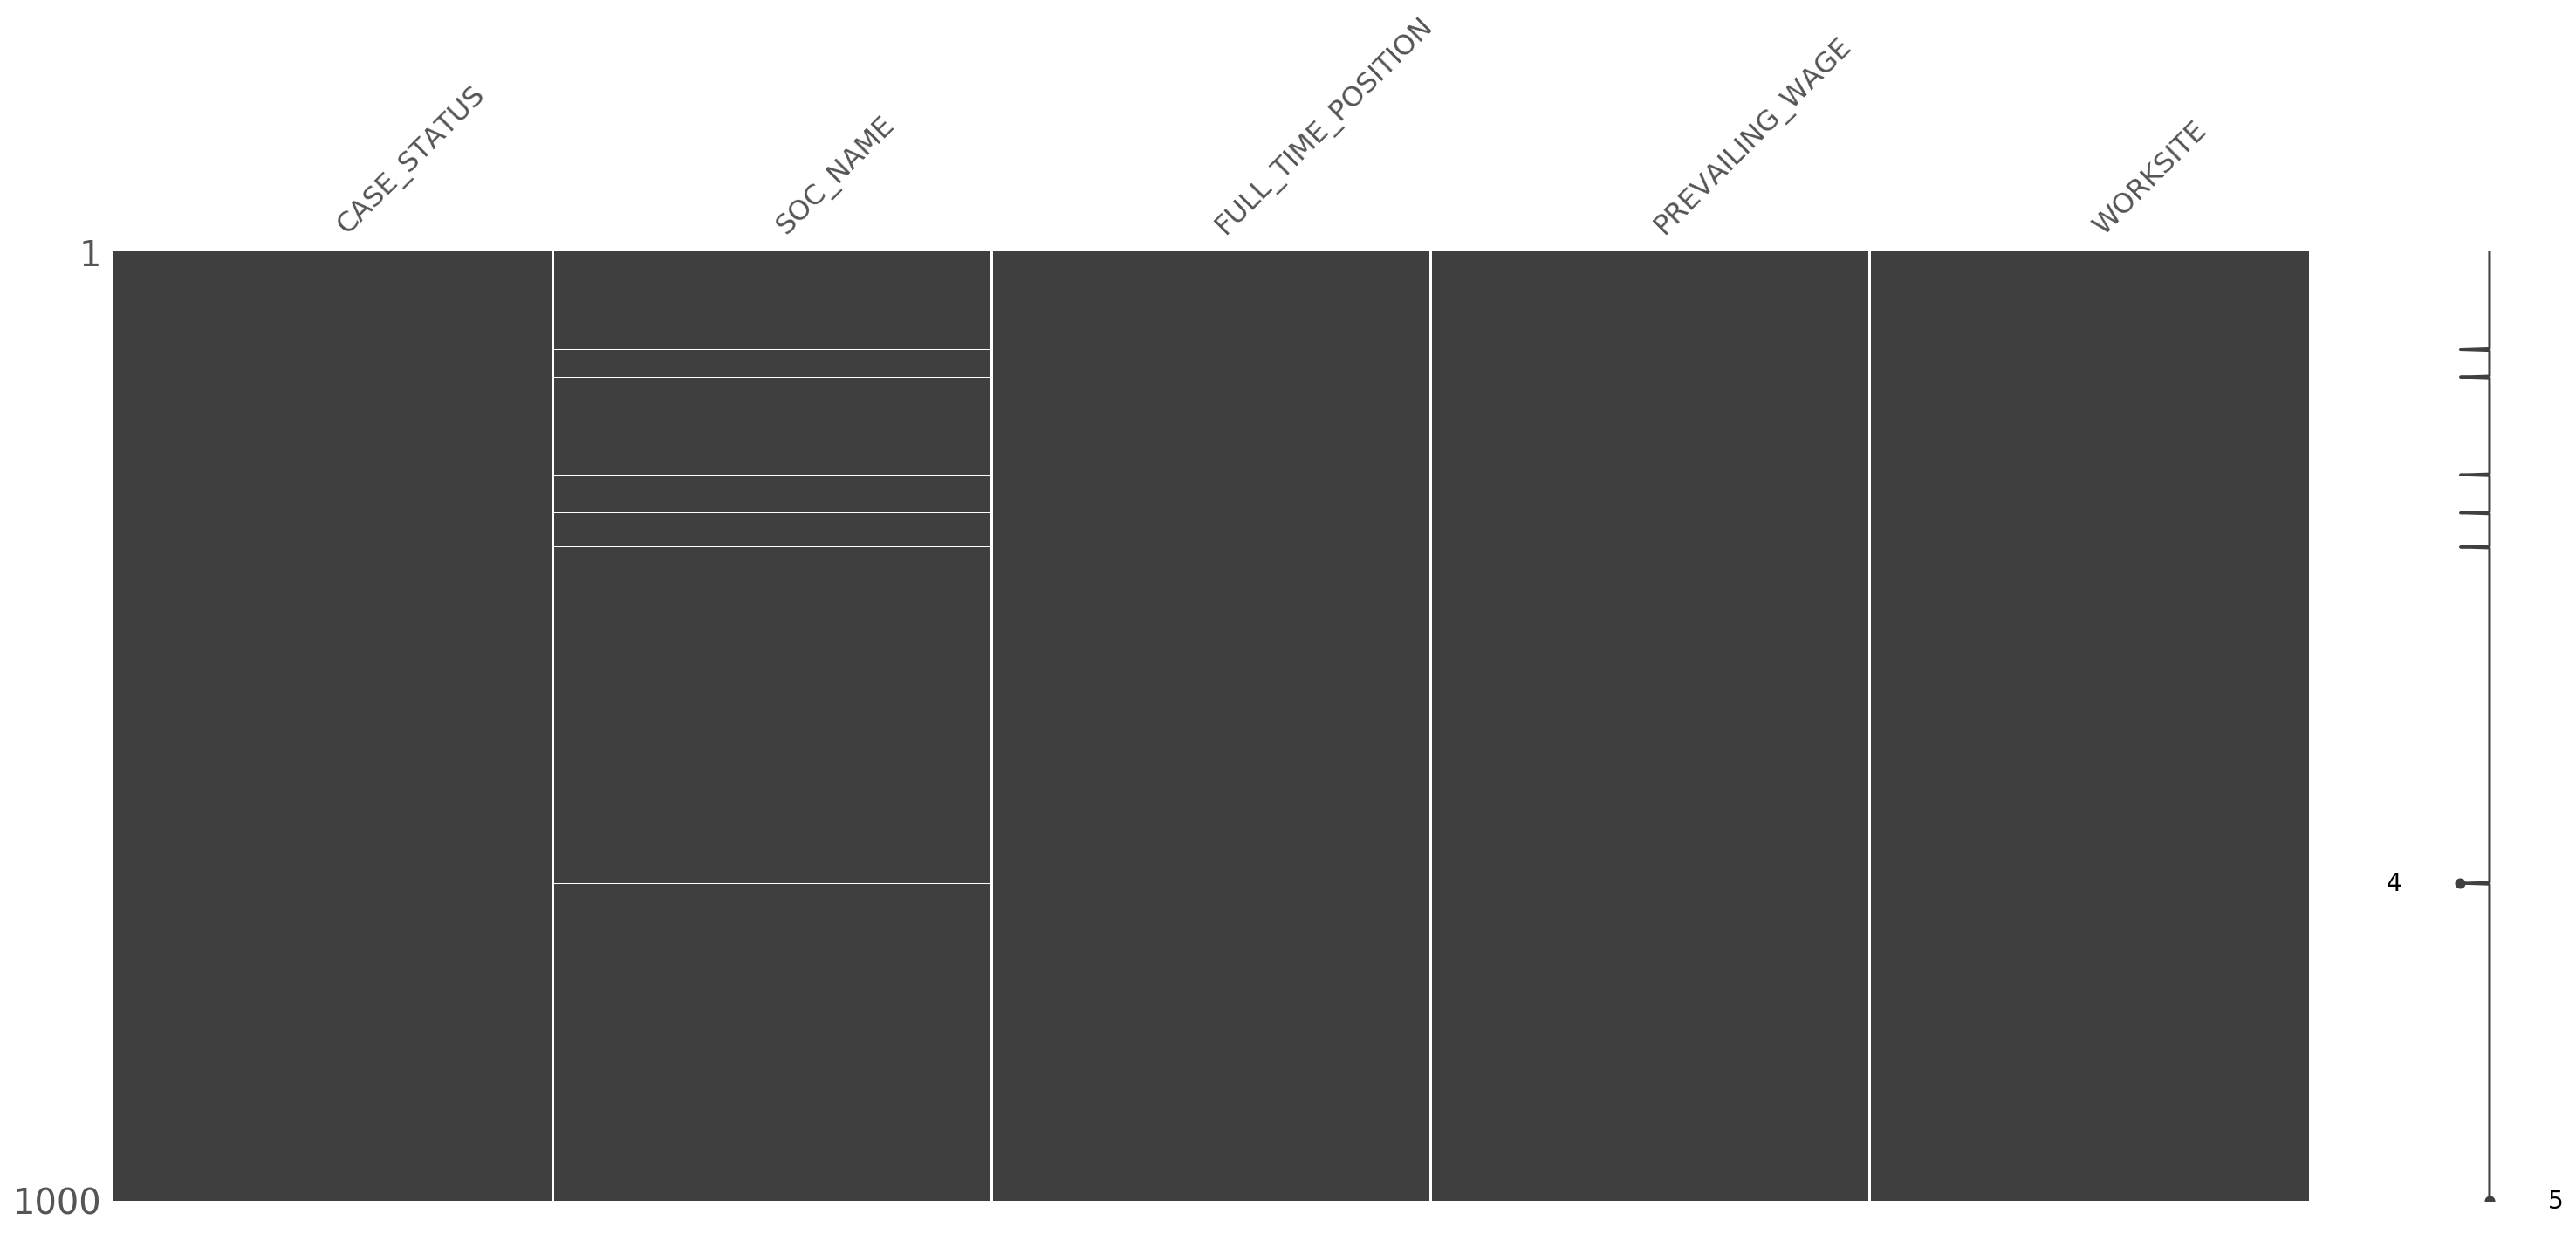

In [4]:
# missing values
msno.matrix(data.sample(1000))

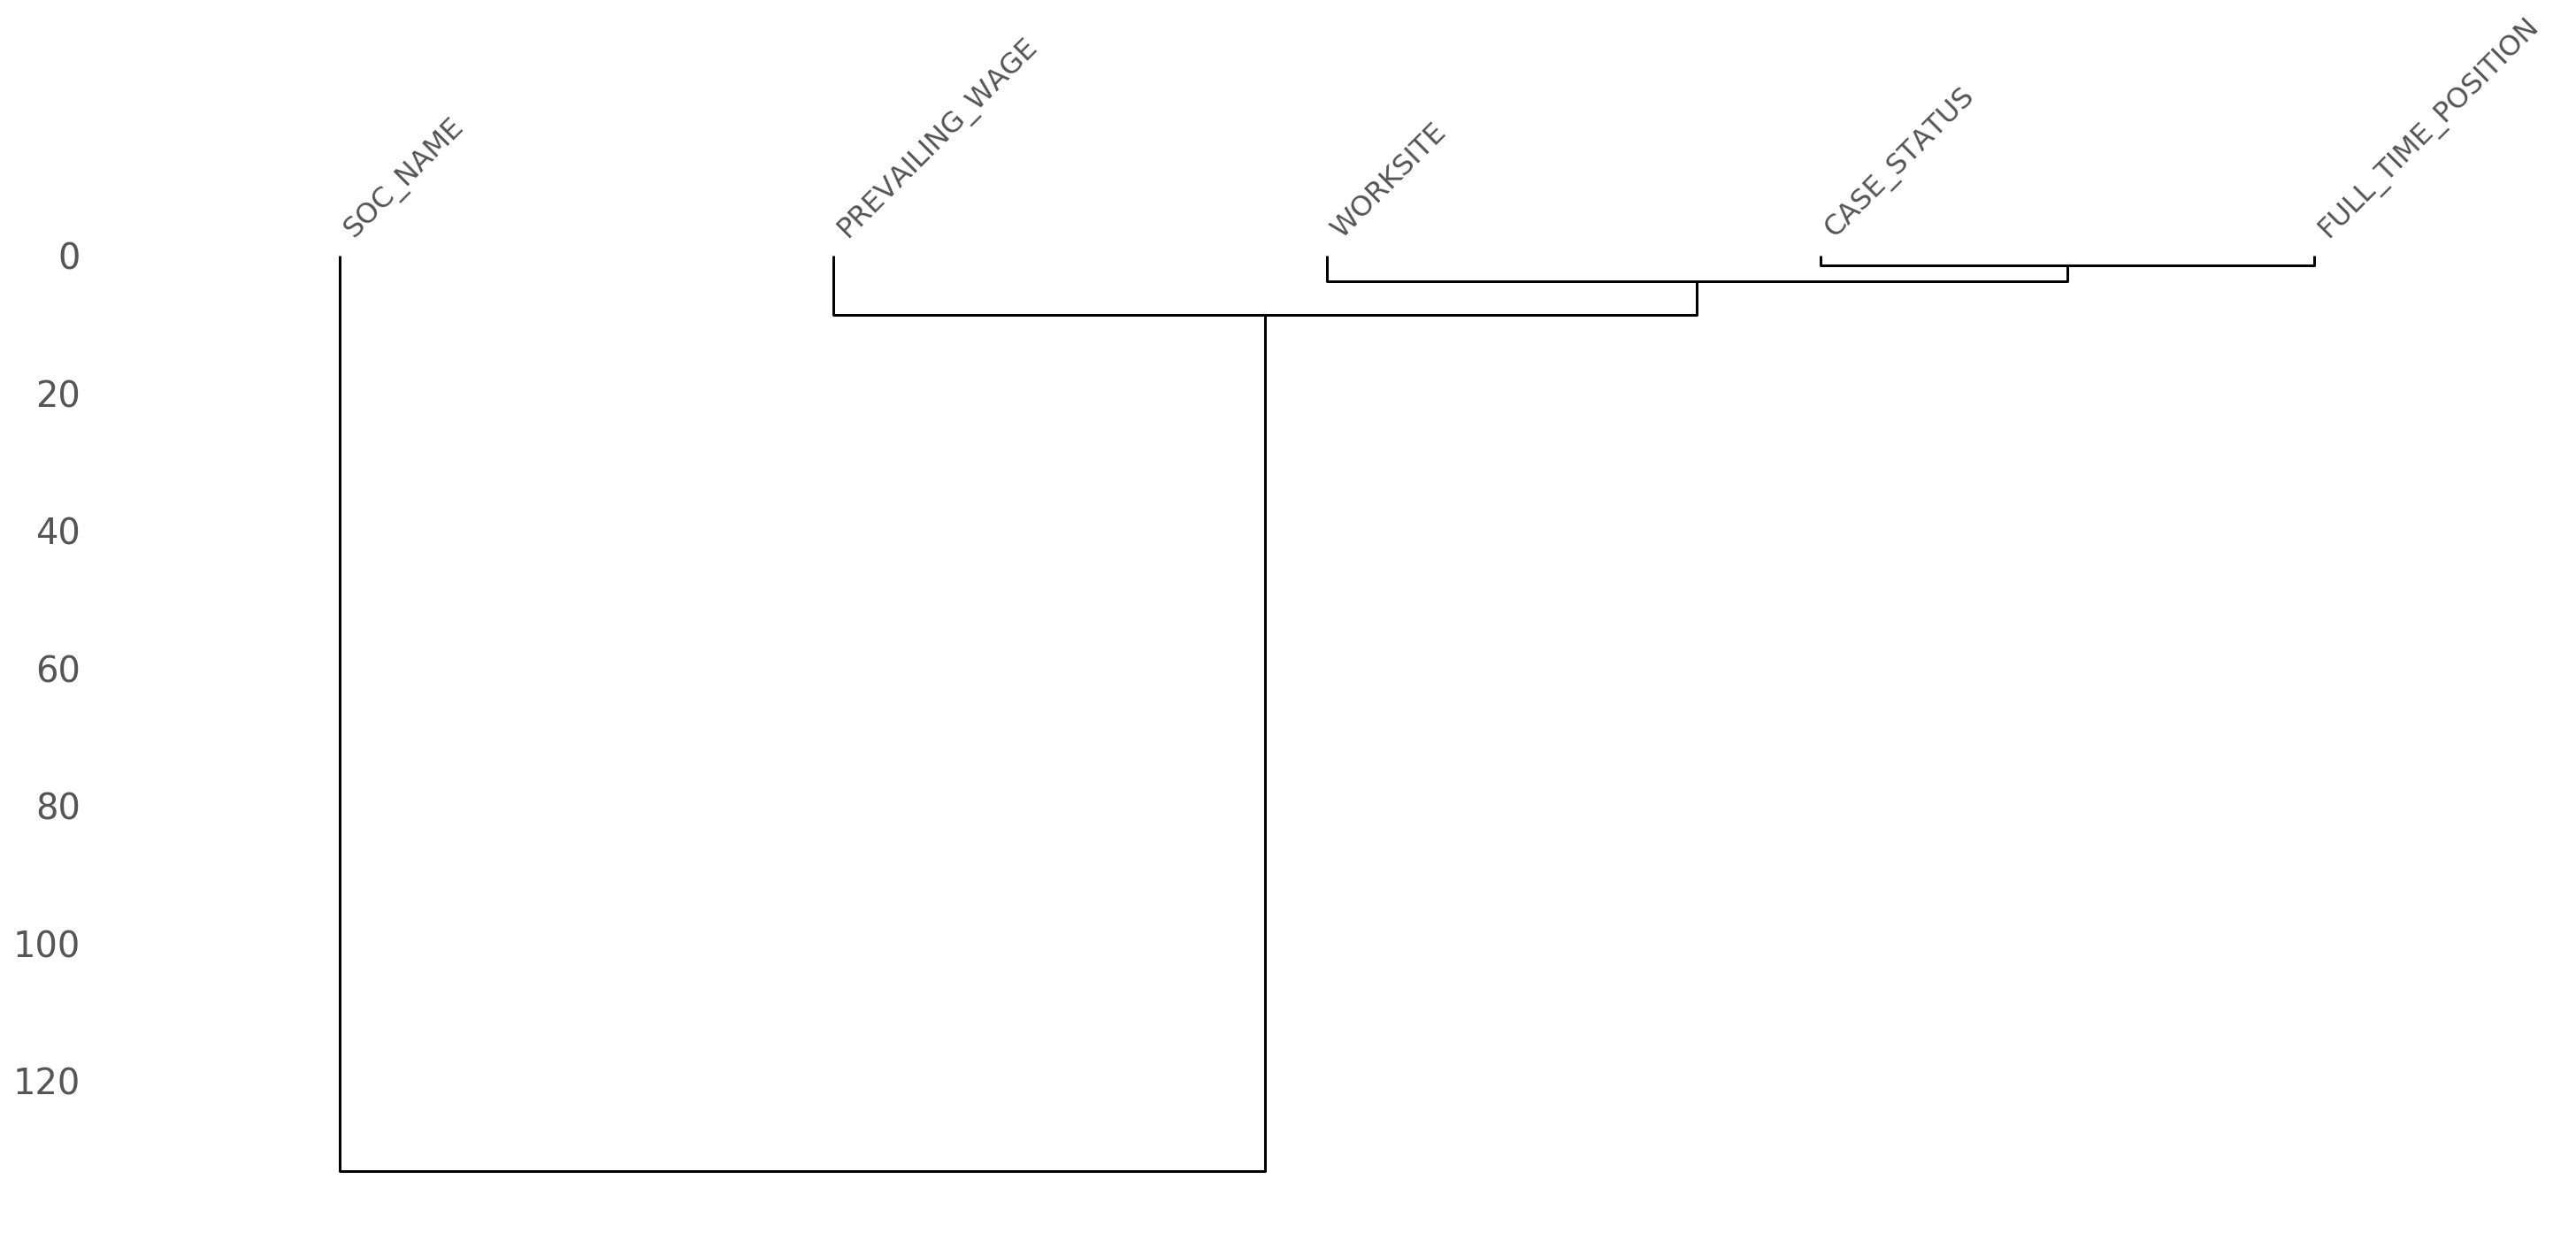

In [5]:
msno.dendrogram(data)

In [6]:
#check the missing data
data.isnull().sum()

CASE_STATUS              13
SOC_NAME              17734
FULL_TIME_POSITION       15
PREVAILING_WAGE          85
WORKSITE                  0
dtype: int64

In [7]:
# remove the missing values
data = data.dropna()

In [8]:
# convert all strings to uppercase 
data['SOC_NAME'] = data['SOC_NAME'].str.upper()

In [9]:
# remove everthing after comma from job title
data['SOC_NAME'] = data['SOC_NAME'].apply(lambda x: x.split(', ')[0])

In [10]:
# There 
data[data['SOC_NAME'].str.contains('CARPI')]

,CASE_STATUS,SOC_NAME,FULL_TIME_POSITION,PREVAILING_WAGE,WORKSITE
1254219,DENIED,<FONT><FONT>CARPINTEROS</FONT></FONT>,Y,25646.4,"SALT LAKE CITY, UTAH"


In [11]:
data = data[~data['SOC_NAME'].str.contains('CARPI')]

Current format of the worksite column is **City Name, State**, for this study we will focus on only state. 

In [12]:
# remove city names from worksite column
data['WORKSITE'] = data['WORKSITE'].apply(lambda x: x.split(', ')[1])

In [13]:
pd.options.display.float_format = '{:,.2f}'.format

data['PREVAILING_WAGE'].describe()

count       2,984,655.00
mean          146,964.69
std         5,296,106.23
min                 0.00
25%            54,350.00
50%            65,000.00
75%            81,432.00
max     6,997,606,720.00
Name: PREVAILING_WAGE, dtype: float64

Clearly, there are outliers in the dataset.

In [14]:
data[(data['PREVAILING_WAGE'] > 500000) | (data['PREVAILING_WAGE'] < 25000)].shape

(11978, 5)

 Approxiametly, 12000 wages are below 25000 or above 500000 dollars, those records will be removed.

In [15]:
cleaned_data = data[(data['PREVAILING_WAGE'] < 500000)]
cleaned_data = cleaned_data[(cleaned_data['PREVAILING_WAGE'] > 25000)]

### 3. Data Exploring

**CASE_STATUS** : This is our target feature. There were 7 possible values in the dataset and we reduced it to 2. Because only one status has a positive result and rest of the statues have a negative result. 

**SOC_NAME** : Type of the job. There are 1584 unique jobs in the dataset.

**FULL_TIME_POSITION** : This column indicates if the job is full time or not. 

**WORKSITE** : Location of the job. Original column had the state and city information. I removed the cities. The model is going to make predictions based on the state information.

In [16]:
# type of columns
cleaned_data.dtypes

CASE_STATUS            object
SOC_NAME               object
FULL_TIME_POSITION     object
PREVAILING_WAGE       float64
WORKSITE               object
dtype: object

In [17]:
print ('Number of records: ', cleaned_data.shape[0])
print ('Number of positive cases: ', cleaned_data['CASE_STATUS'].value_counts()[0])
print ('Number of negative cases: ', cleaned_data['CASE_STATUS'].value_counts()[1])
print ('Percentage of positive cases: ', \
       cleaned_data['CASE_STATUS'].value_counts()[0] * 100 / cleaned_data.shape[0])

Number of records:  2972646
Number of positive cases:  2593332
Number of negative cases:  200845
Percentage of positive cases:  87.2398529795


After removing the null values, we still have close to 3 million records. There are 4 features which are SOC_NAME, FULL_TIME_POSITION, PREVAILING_WAGE and WORKSITE. Our target value is CASE_STATUS. 

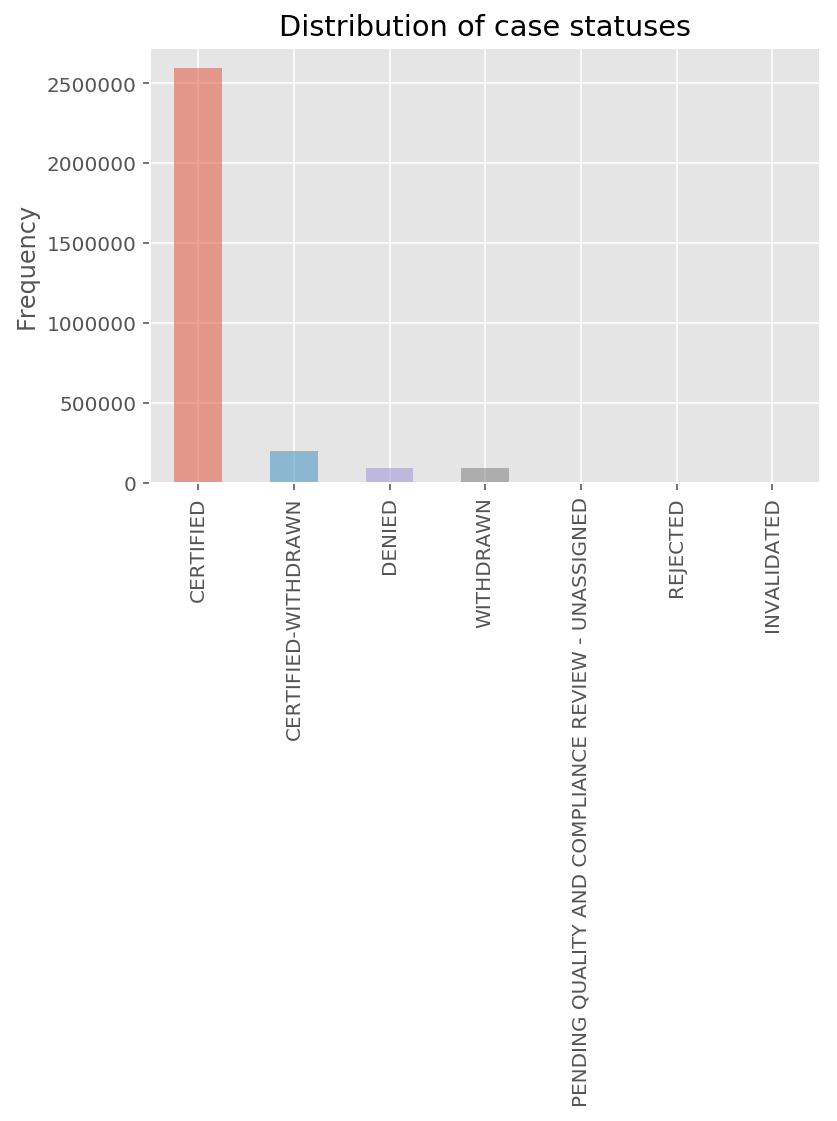

In [18]:
cleaned_data['CASE_STATUS'].value_counts().plot(kind='bar', alpha=0.5)
plt.title('Distribution of case statuses')
plt.ylabel('Frequency')
plt.savefig('Distribution_of_case_status.png');

We have more positive case results than negative results. 

In [19]:
# number of unique values in each column
for column in cleaned_data:
    print(column, cleaned_data[column].nunique())   

CASE_STATUS 7
SOC_NAME 1250
FULL_TIME_POSITION 2
PREVAILING_WAGE 52661
WORKSITE 53


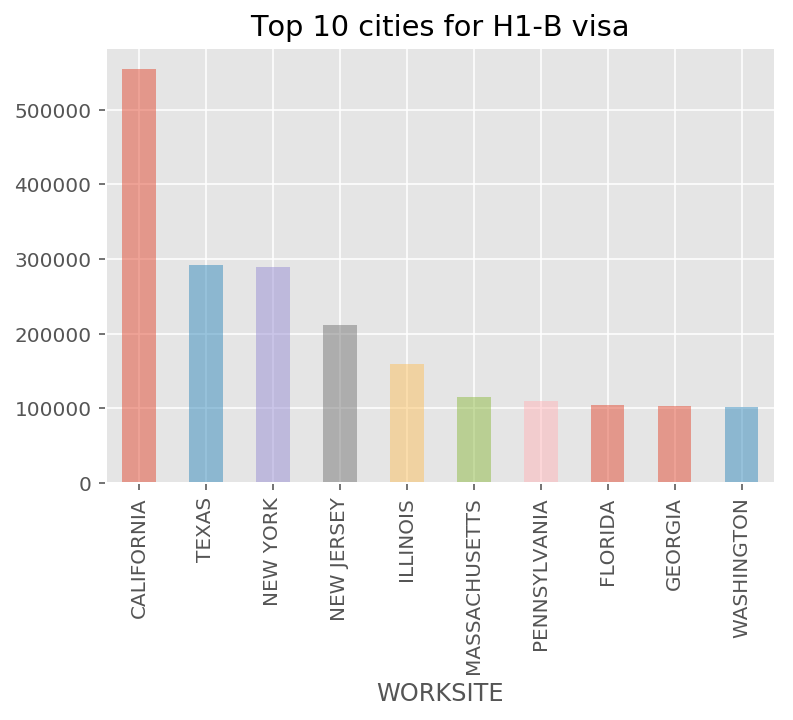

In [20]:
cleaned_data['WORKSITE'].groupby(cleaned_data['WORKSITE']).count()\
                .sort_values(ascending=False).head(10).plot(kind='bar', alpha=0.5)
plt.title('Top 10 cities for H1-B visa')
plt.savefig('Top_cities.png');

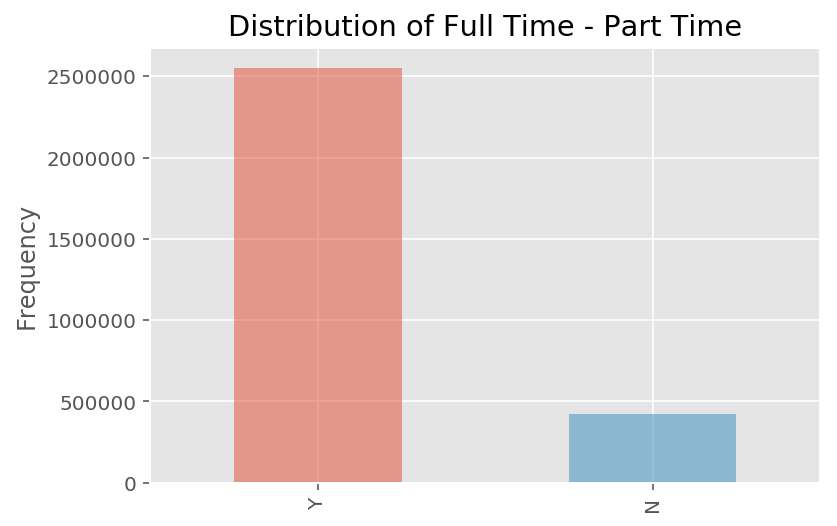

In [21]:
cleaned_data['FULL_TIME_POSITION'].value_counts().plot(kind='bar', alpha=0.5)
plt.title('Distribution of Full Time - Part Time')
plt.ylabel('Frequency');

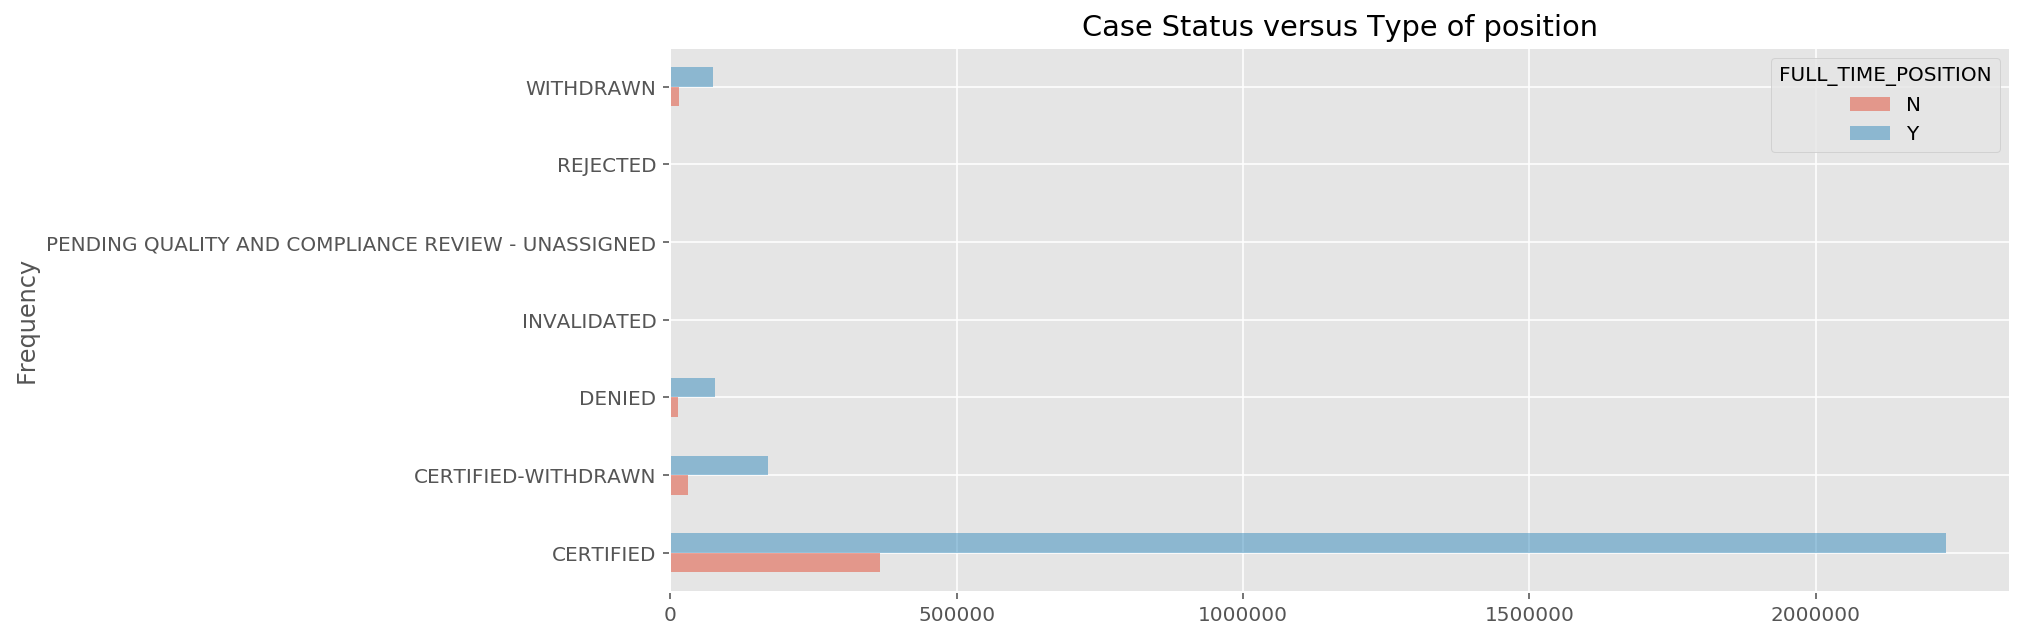

In [22]:
cleaned_data.groupby(['CASE_STATUS','FULL_TIME_POSITION']).count()['SOC_NAME'].\
            unstack().plot(kind='barh',figsize=(12,5), alpha=0.5)
plt.title('Case Status versus Type of position')
plt.ylabel('Frequency');

In [23]:
cleaned_data.pivot_table(values=['CASE_STATUS'], index=['FULL_TIME_POSITION'], aggfunc=('count'))

,CASE_STATUS
FULL_TIME_POSITION,
N,424129
Y,2548517


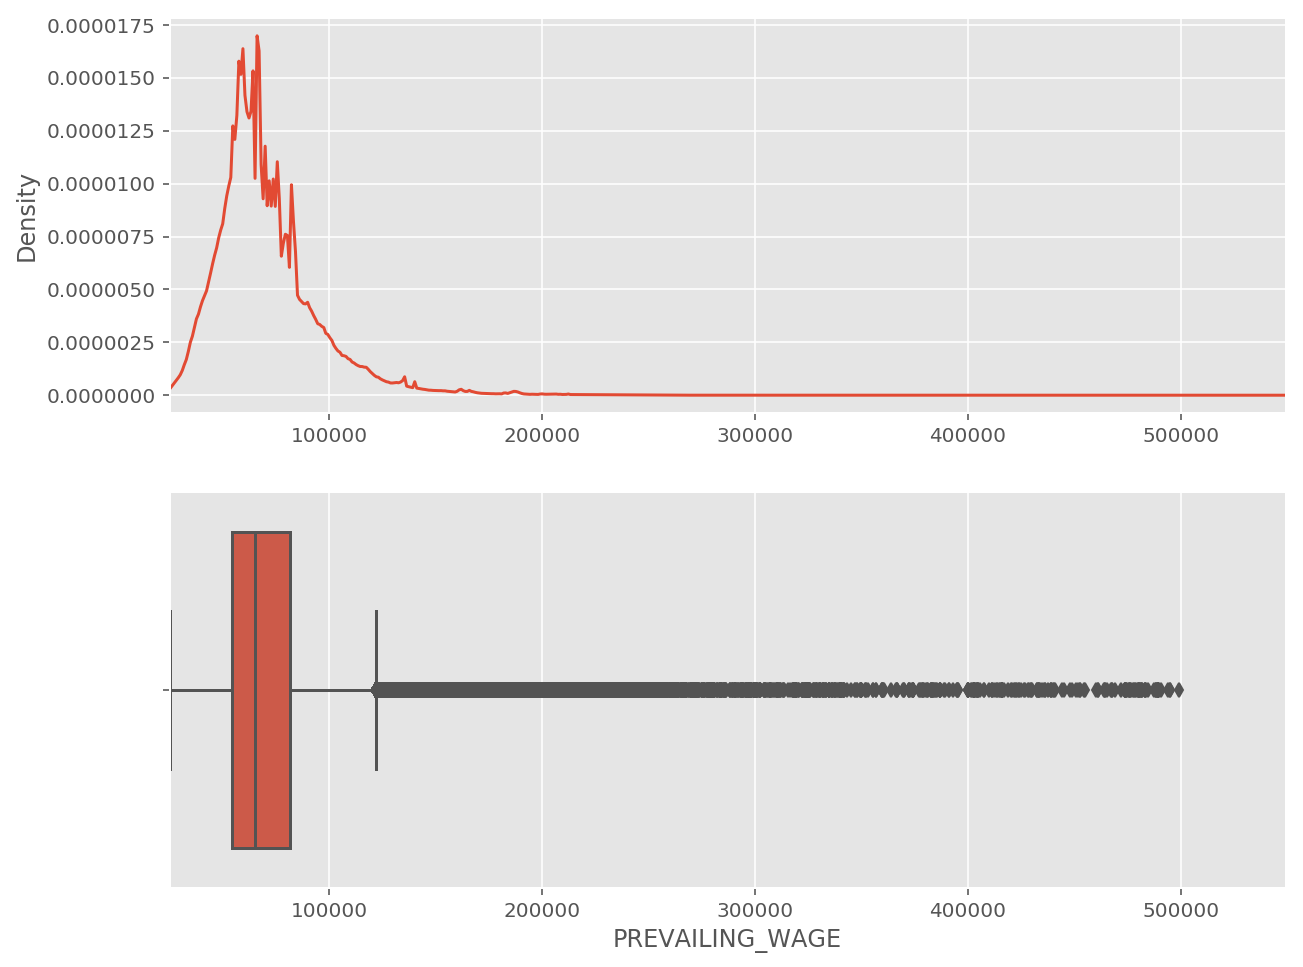

In [24]:
i = 'PREVAILING_WAGE'

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)

ax = cleaned_data[i].plot(kind='kde')

plt.subplot(212)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)
sns.boxplot(x=cleaned_data[i]);

Here we have two plots, the density plot and the box plot. This is a good way to view the data as we can see in the density plot (top) that there is some data points in the tails but it is difficult to see, however it is clear in the box plot.

### 4. Data Transformation and Processing

#### 4.1 Data Transformation

For highly sckewed features, it is always good to do transformation. **PREVAILING_WAGE** column has tail on the right and we will apply logarithmic transformation on it. 

In [25]:
# log transform the data
cleaned_data['Log_' + i] = np.log(cleaned_data[i])

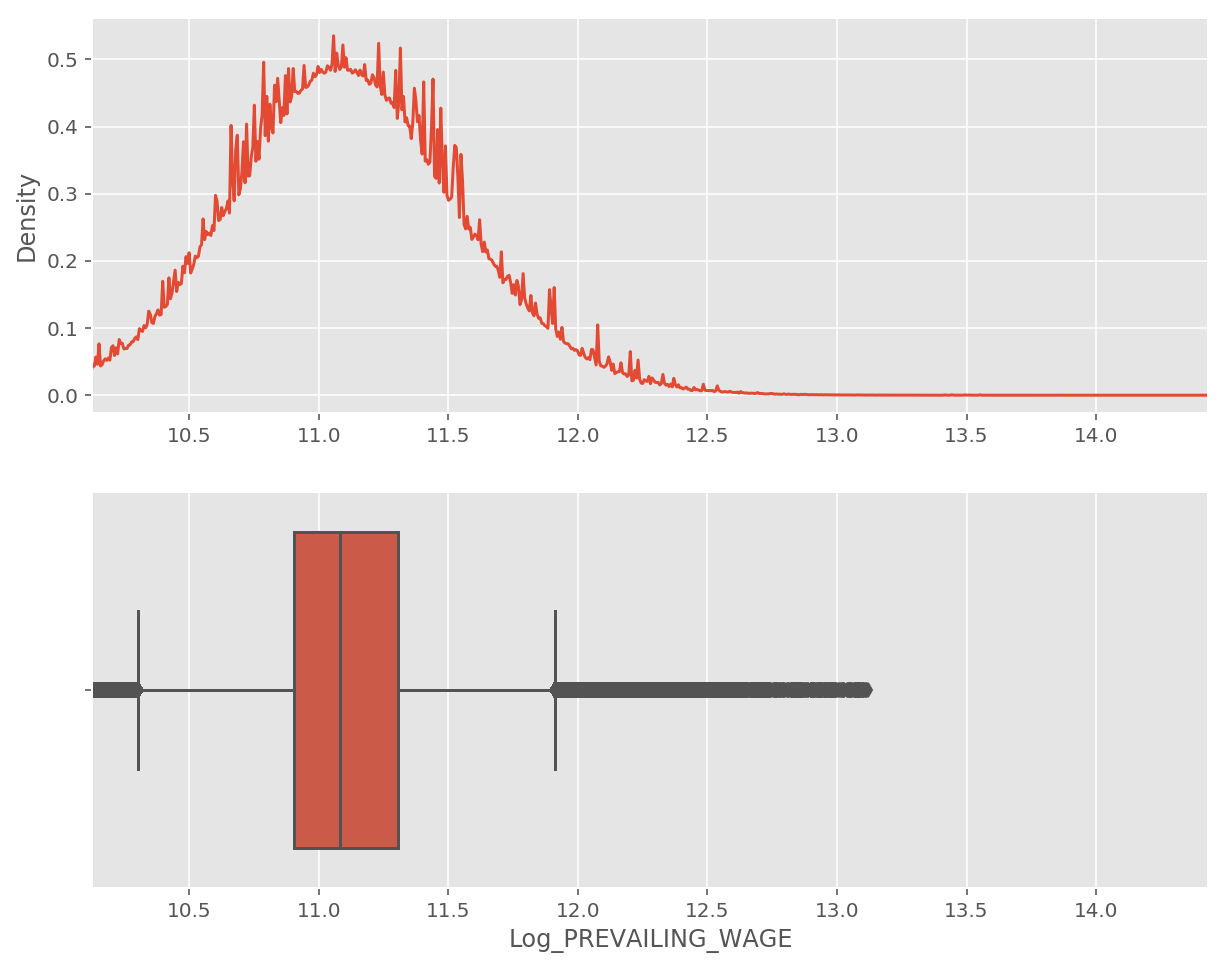

In [26]:
i = 'Log_PREVAILING_WAGE'

plt.figure(figsize=(10,8))
plt.subplot(211)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)

ax = cleaned_data[i].plot(kind='kde')

plt.subplot(212)
plt.xlim(cleaned_data[i].min(), cleaned_data[i].max()*1.1)
sns.boxplot(x=cleaned_data[i]);

time to scale transformed data 

In [27]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import RobustScaler

# Initialize a scaler, then apply it to the features
scaler = RobustScaler() # default=(0, 1)
numerical = ['Log_PREVAILING_WAGE']

transformed_data = pd.DataFrame(data = cleaned_data)
transformed_data[numerical] = scaler.fit_transform(cleaned_data[numerical])

In [28]:
# remove original wage column 
del transformed_data['PREVAILING_WAGE']

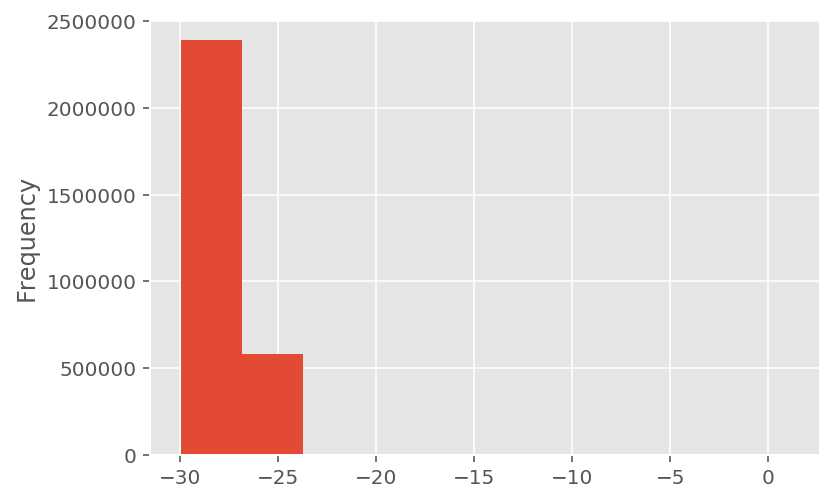

In [29]:
transformed_data['Log_PREVAILING_WAGE'].plot(kind='hist');

#### 4.1 Data Processing

In [30]:
transformed_data['CASE_STATUS'].unique()

array(['CERTIFIED-WITHDRAWN', 'WITHDRAWN', 'CERTIFIED', 'DENIED',
       'REJECTED', 'INVALIDATED',
       'PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED'], dtype=object)

There are seven types of case statues but only the "CERTIFIED" have a positive result. 

In [31]:
# only certified is 1 others 0
transformed_data['CASE_STATUS'] = transformed_data['CASE_STATUS'].apply(lambda x: 1 if x == 'CERTIFIED' else 0)

In [32]:
# One-hot encode the transformed data using pandas.get_dummies()
features_final = pd.get_dummies(transformed_data, columns=['SOC_NAME', 'FULL_TIME_POSITION', 'WORKSITE'])

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print ("total features after one-hot encoding: ", len(encoded))

total features after one-hot encoding:  1307


In [33]:
# name of features after one-hot encoding
#print (encoded)

In [34]:
print ("Shape of final features: ", (features_final.shape))

#first 5 rows
features_final.head()

Shape of final features:  (2972646, 1307)


,CASE_STATUS,Log_PREVAILING_WAGE,SOC_NAME_13-2011.01,SOC_NAME_15-1121,SOC_NAME_15-1132,SOC_NAME_15-1199.01,SOC_NAME_15-1199.01 SW QUALITY ASSURANCE ENGNRS & TESTERS,SOC_NAME_15-1199.08,SOC_NAME_17-2051,SOC_NAME_17-2072,...,WORKSITE_SOUTH DAKOTA,WORKSITE_TENNESSEE,WORKSITE_TEXAS,WORKSITE_UTAH,WORKSITE_VERMONT,WORKSITE_VIRGINIA,WORKSITE_WASHINGTON,WORKSITE_WEST VIRGINIA,WORKSITE_WISCONSIN,WORKSITE_WYOMING
1,0,-29.03,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,-24.29,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,-24.86,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,-24.53,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,-25.37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


4.2 Train-Test Split

In [35]:
# select 500,000 samples
features_final = features_final.sample(n=500000)

In [36]:
X = features_final.iloc[:,1:]
y = features_final['CASE_STATUS']

In [37]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print ("Training set has samples: ", (X_train.shape[0]))
print ("Testing set has samples: ",  (X_test.shape[0]))

Training set has samples:  400000
Testing set has samples:  100000


### 5. Data Modeling

In [38]:
import time
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [39]:
# Train logistic regression model
start = time.time()
clf_log = LogisticRegression(random_state = 0)
clf_log.fit(X_train, y_train)
end = time.time()

training_time = end - start
print ("Trainig time - Logistic Regression: ",training_time)

Trainig time - Logistic Regression:  25.482961893081665


In [40]:
start = time.time()
clf_random = RandomForestClassifier(random_state = 0)
clf_random.fit(X_train, y_train)
end = time.time()

training_time = end - start
print ("Trainig time - Random Forest: ",training_time)

Trainig time - Random Forest:  86.27110314369202


In [41]:
start = time.time()
clf_xg = XGBClassifier(random_state = 0)
clf_xg.fit(X_train, y_train)
end = time.time()
training_time = end - start
print ("Trainig time - XGBoost: ",training_time)

Trainig time - XGBoost:  3532.4018409252167


In [42]:
training_times = {'model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
                   'time': [24, 70, 3038]
                 }
training_times_df = pd.DataFrame(training_times, columns = ['model','time'])

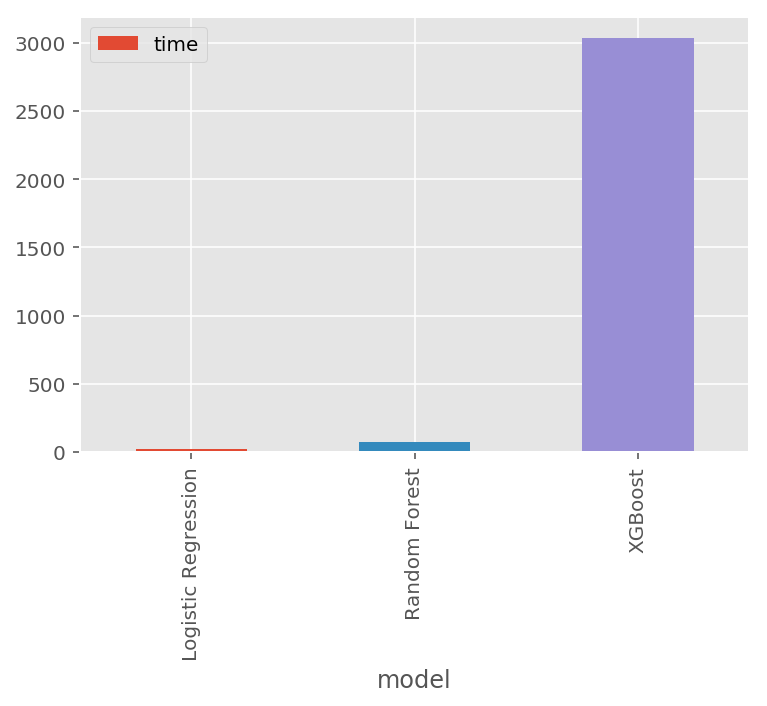

In [43]:
training_times_df.plot('model', 'time', kind='bar');

### 6. Model Evaluation

Naive predictor

In [44]:
# Calculate accuracy, precision and recall
TP = np.sum(y) # positive resulted visas
TN = 0
FP = y.count() - np.sum(y) # negative visas
FN = 0

accuracy = TP / (TP + FP)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / ((beta**2 * precision) + recall)

# Print the results 
print ("Naive Predictor\nAccuracy score:", accuracy, "\nF(0.5)-score:" ,fscore)

Naive Predictor
Accuracy score: 0.871438 
F(0.5)-score: 0.894436098745


#### Measuring accuracy using Cross Validation

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, fbeta_score, roc_curve, roc_auc_score, accuracy_score

CV accuracy score: 0.871717500067

Precision score:  0.87178012592
F(0.5) score 0.894709262729


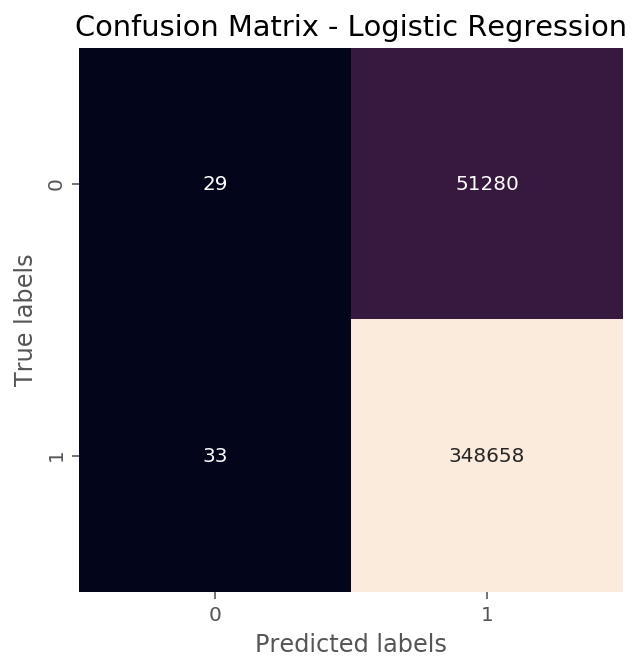

In [46]:
cross_val_accuracy = cross_val_score(clf_log, X_train, y_train, cv=3, scoring="accuracy").mean()
print ("CV accuracy score:", cross_val_accuracy)
y_train_pred = cross_val_predict(clf_log, X_train, y_train, cv=3)
print ("")
plt.figure(figsize=(10,5))
mat = confusion_matrix(y_train, y_train_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.title('Confusion Matrix - Logistic Regression')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

print ("Precision score: ",precision_score(y_train, y_train_pred))
print ("F(0.5) score", fbeta_score(y_train, y_train_pred, beta=0.5))

ROC AUC score:  0.604193153185


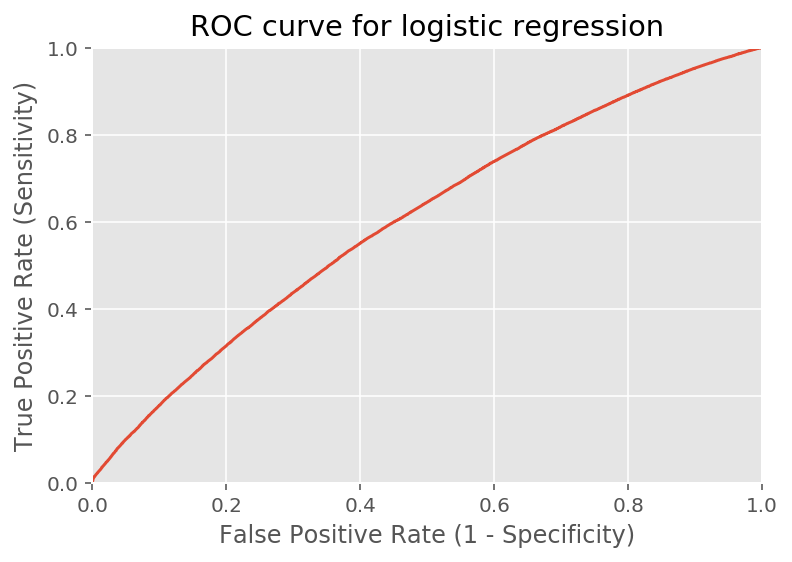

In [47]:
y_scores_log = cross_val_predict(clf_log, X_train, y_train, cv=3, method='predict_proba')
y_scores_log = y_scores_log[:,1]  # ROC curve requires scores not probability

fpr_log, tpr_log, thresholds_log = roc_curve(y_train, y_scores_log)
plt.plot(fpr_log, tpr_log)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for logistic regression')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print ("ROC AUC score: ", roc_auc_score(y_train, y_scores_log))

CV accuracy score: 0.843637501211

Precision_score:  0.878572108973
f0.5_score 0.892379231812


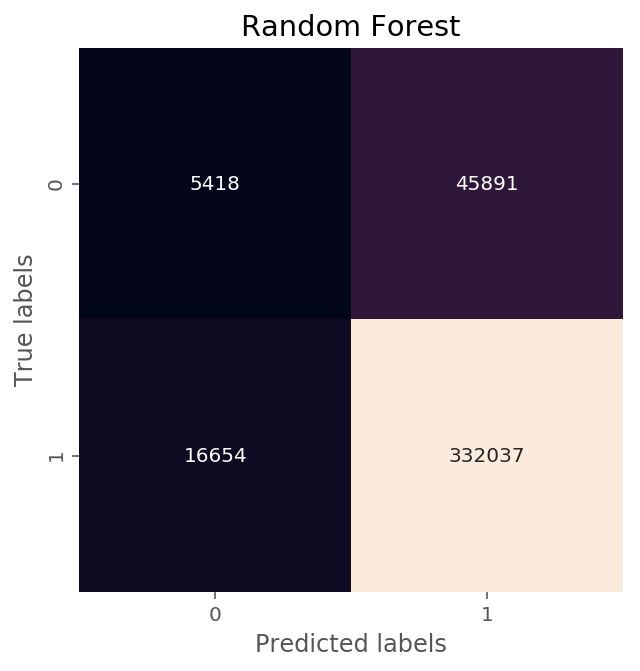

In [48]:
cross_val_accuracy = cross_val_score(clf_random, X_train, y_train, cv=3, scoring="accuracy").mean()
print ("CV accuracy score:", cross_val_accuracy)
y_train_pred = cross_val_predict(clf_random, X_train, y_train, cv=3)
print ("")
plt.figure(figsize=(10,5))
mat = confusion_matrix(y_train, y_train_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.title('Random Forest')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

print ("Precision_score: ",precision_score(y_train, y_train_pred))
print ("f0.5_score", fbeta_score(y_train, y_train_pred, beta=0.5))

ROC AUC score:  0.574720953989


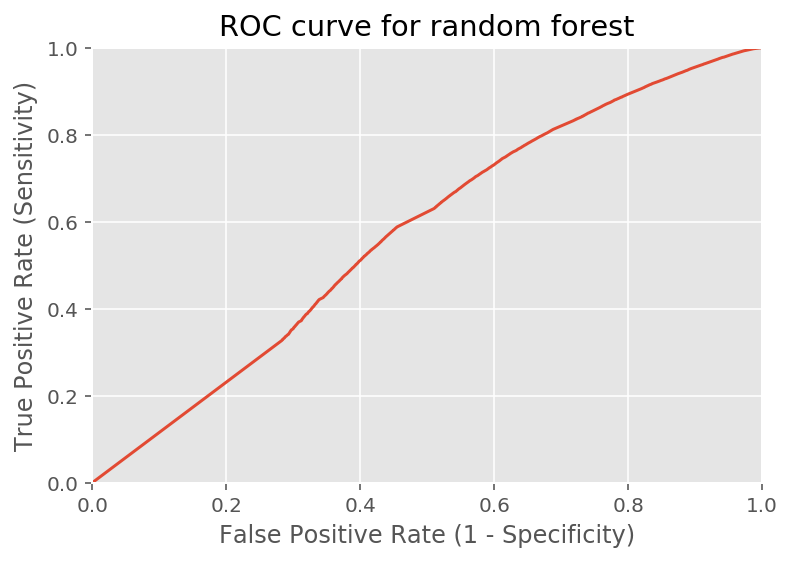

In [49]:
y_scores_random = cross_val_predict(clf_random, X_train, y_train, cv=3, method='predict_proba')
y_scores_random = y_scores_random[:,1]  # ROC curve requires scores not probability

fpr_random, tpr_random, thresholds_random = roc_curve(y_train, y_scores_random)
plt.plot(fpr_random, tpr_random)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for random forest')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print ("ROC AUC score: ", roc_auc_score(y_train, y_scores_random))

CV accuracy score: 0.871727499998

Precision_score:  0.8717275
f0.5_score 0.894680069852


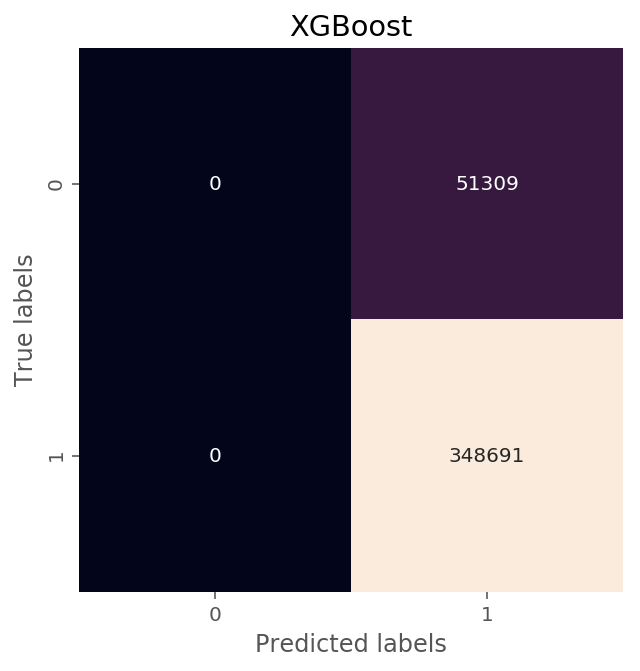

In [50]:
cross_val_accuracy = cross_val_score(clf_xg, X_train, y_train, cv=3, scoring="accuracy").mean()
print ("CV accuracy score:", cross_val_accuracy)
y_train_pred = cross_val_predict(clf_xg, X_train, y_train, cv=3)
print ("")
plt.figure(figsize=(10,5))
mat = confusion_matrix(y_train, y_train_pred)
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False)
plt.title('XGBoost')
plt.ylabel('True labels')
plt.xlabel('Predicted labels');

print ("Precision_score: ",precision_score(y_train, y_train_pred))
print ("f0.5_score", fbeta_score(y_train, y_train_pred, beta=0.5))

ROC AUC score:  0.602930144073


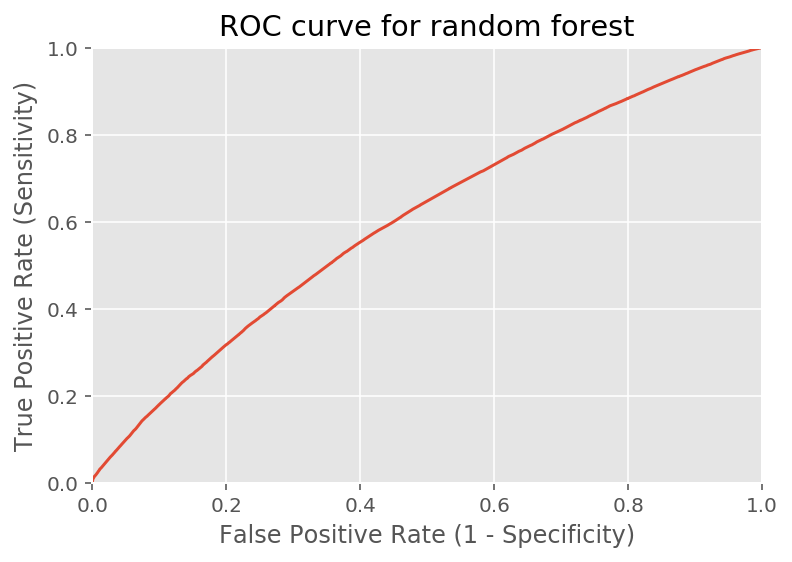

In [51]:
y_scores_xg = cross_val_predict(clf_xg, X_train, y_train, cv=3, method='predict_proba')
y_scores_xg = y_scores_xg[:,1]  # ROC curve requires scores not probability

fpr_xg, tpr_xg, thresholds_xg = roc_curve(y_train, y_scores_xg)
plt.plot(fpr_xg, tpr_xg)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for XGBoost')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
print ("ROC AUC score: ", roc_auc_score(y_train, y_scores_xg))

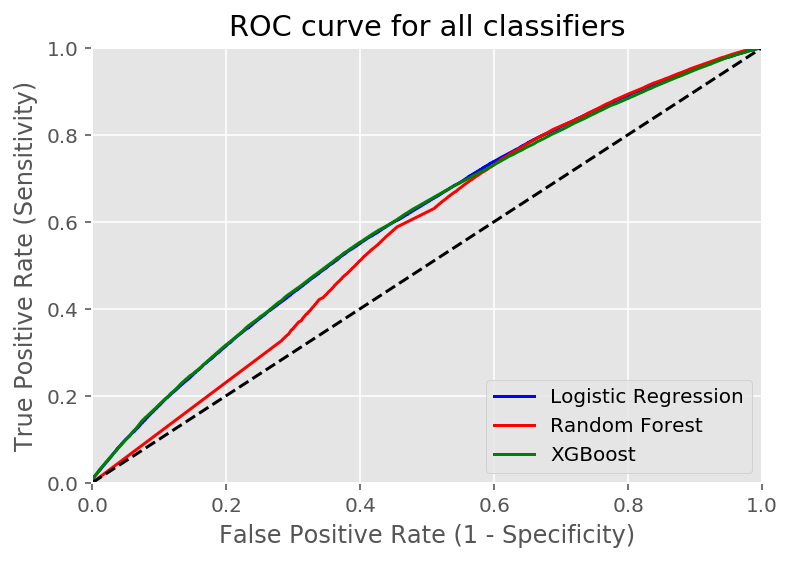

In [52]:
plt.figure()
plt.plot(fpr_log, tpr_log, "b", label='Logistic Regression')
plt.plot(fpr_random, tpr_random, "r", label='Random Forest')
plt.plot(fpr_xg, tpr_xg, "g", label='XGBoost')
plt.plot([0,1], [0,1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve for all classifiers')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.legend(loc='lower right')
plt.show()

#### Model tuning

In [53]:
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state=0)

# TODO: Create the parameters list you wish to tune, using a dictionary if needed.
# HINT: parameters = {'parameter_1': [value1, value2], 'parameter_2': [value1, value2]}
parameters = {'penalty':['l1','l2']
              ,'C':[0.1, 1, 5, 10]
              ,'tol':[0.00001, 0.0001, 0.001]
             }

# TODO: Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(fbeta_score, beta=0.5)

# TODO: Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(clf, param_grid=parameters, scoring=scorer)

# TODO: Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_
print ("Best clf's hyperparameters:\n")
print (best_clf)

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

# Report the before-and-afterscores
print ("\nUnoptimized model\n------")
print ("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print ("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print ("\nOptimized Model\n------")
print ("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print ("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Best clf's hyperparameters:

LogisticRegression(C=5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=1e-05,
          verbose=0, warm_start=False)

Unoptimized model
------
Accuracy score on testing data: 0.8703
F-score on testing data: 0.8935

Optimized Model
------
Final accuracy score on the testing data: 0.8703
Final F-score on the testing data: 0.8936
